<a href="https://colab.research.google.com/github/Siqi-Fang/BrawlStar_Classification/blob/main/BrawlStars_Win_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TL;DR#
The project focuses on predicting the outcome of a Brawl Star match with pre-game information using classification models. The data used for training an testing are collected from Supercell API. Tree based models have shown best results with Random Forest achieving 87% accuracy score.

Results from the project showed that pre-game inforamtion are complicated and context dependent. Thus, models may be trained towards more targeted goals(for example, trained to predict selected game mode only) to achieve higher accuracy and be applied in practice.


#Background
Brawl Start is a multiplayer online battle mobile game that features multiple game modes. In our project, we focus on game modes that feature 2 teams of 3 players. Our goal is to make prediction of a game outcome with **pre-game statistics**. 
Players choose from a selection of Brawlers, which are characters that can be controlled with on-screen joysticks in a game match.
More information is provided in data section.

#Goals
Our initial assumption is that, since the game is easy to pick up, pre-game information such as brawler choice is highly predicative of the match outcome. We also tested features that reflect a player's experience level in our model. 

Possible applications:

- Recommend teams for amature players to help them strategize.
- Help making balance change decisions when developing new maps or brawlers. 


#Basic Packages

In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# visualization modules
import seaborn as sns
import matplotlib.pyplot as plt

# The Data
Data are from Supercell API. I used [this](https://brawlstats.readthedocs.io/en/latest/api.html) wrapper to collect the data. Its object oriented design is convinient for data transformation. 


Here is a list of features used in this project. 


Feature|Type|Description
--------|--------|-------- 
result|object| Game result: victory, defeat, draw
mode|object| There are different game modes in the game, each with different goal/criterion to win
brawler|object| The character the player controls in a match
power|float64| The power level of the brawler selected range  [1-11]
b_trophies|float64| The number of trophies of a selected brawler, higher trophies indicate more experience with the brawler
map|object| Map of a match, dependent on game mode
p_trophies|float64| The sum of trophy number of all brawlers owned by a player, gets reset every a new season
exp_level|float64|Experince level of the player, similar to trophy but is cumulative
3v3_win|float64|Number of 3v3 team play game won
solo_win|float64| Number of solo showdown game won
duo_win|float64|Number of duo showdown game won
trophy_difference|float64|Calculated by taking the average brawler trophy of each team 
power_difference|float64|Calculated by taking the average brawler power of each team 

|index|result|mode|brawler|power|b\_trophies|map|p\_trophies|3v3\_win|solo\_win|duo\_win|exp\_level|trophy\_difference|power\_difference|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|0|victory|gemGrab|TARA|10\.0|1043\.0|Flooded Mine|54761\.0|29761\.0|1916\.0|1163\.0|288\.0|340\.67|0\.0|
|1|victory|gemGrab|TARA|10\.0|1038\.0|Flooded Mine|54761\.0|29761\.0|1916\.0|1163\.0|288\.0|367\.33|1\.33|
|2|victory|gemGrab|TARA|10\.0|1033\.0|Flooded Mine|54761\.0|29761\.0|1916\.0|1163\.0|288\.0|346\.0|0\.67|
|3|victory|gemGrab|TARA|10\.0|1028\.0|Flooded Mine|54761\.0|29761\.0|1916\.0|1163\.0|288\.0|282\.67|1\.33|
|4|victory|gemGrab|TARA|10\.0|1023\.0|Flooded Mine|54761\.0|29761\.0|1916\.0|1163\.0|288\.0|248\.67|0\.33|
|5|victory|gemGrab|TARA|10\.0|1018\.0|Flooded Mine|54761\.0|29761\.0|1916\.0|1163\.0|288\.0|239\.33|0\.33|
|6|victory|gemGrab|TARA|10\.0|1013\.0|Flooded Mine|54761\.0|29761\.0|1916\.0|1163\.0|288\.0|358\.67|1\.0|
|7|victory|gemGrab|TARA|10\.0|1008\.0|Flooded Mine|54761\.0|29761\.0|1916\.0|1163\.0|288\.0|394\.0|0\.0|
|8|victory|gemGrab|TARA|10\.0|1003\.0|Flooded Mine|54761\.0|29761\.0|1916\.0|1163\.0|288\.0|319\.33|0\.33|
|9|defeat|gemGrab|PIPER|9\.0|938\.0|Flooded Mine|54761\.0|29761\.0|1916\.0|1163\.0|288\.0|19\.0|-0\.33|

Features that were removed:

map & brawler & mode : on their own they don't provide any information since the game is designed to be balanced. But some brawler works better on some maps, so we combine them with general statistics to create new feature, win_rate.

solo_win, duo_win, 3v3_win: They count the number of wins in different modes, so only have meaning when comparison is made. They are combined to make team_win_ratio feature.

power*: Our dataset have low variance in this feature. But this is not the case if we can extend our data to include amateur players.

##Data Collection
To use the wrapper, install its package and visite [Supercell API](https://developer.brawlstars.com) to create your auth token.

It take ~30 mins to run code in this section and generate ~180k data entires.

In [ ]:
pip install brawlstats


Supercell API allows collection of the 25 most recent battle logs by inputting player tag(id). It also provides a list of the top 200 players in a region. 
So we will first generates a list of top players' tags, and fetch their recent battle logs as our data.



In [ ]:
import brawlstats
# country code is needed to generate player list 
COUNTRY_CODE = ["JP", "BR", "SG", "ES","CN", "UK", "FR","US", "RU", "IT", "CA", 
        "AT", "UA", "MD","PR", "DK", "KR", "NO", "DE", "HK", 'FI', "MO", "SE"]
tags = []

MY_TOKEN = # get your token from Supercell API website
client = brawlstats.Client(MY_TOKEN)

def createPlayerList():
    """ Stores a list of player id into a list 
    """
    for code in COUNTRY_CODE:
        players = client.get_rankings(ranking='players',region=code)
        for player in players:
                tags.append(player.tag)  

In [ ]:
createPlayerList() 

In [ ]:
# the features API can provide
# visite their website for full description 
"""
player_col = ['trophies', 'power_play_points', 'exp_level', 'x3vs3_victories',
              'solo_victories', 'duo_victories']
battle_col = ['event.map','battle.mode', 'battle.rank', 'battle.teams']

battle_data = pd.DataFrame(columns=['result','mode','brawler','power','b_trophies',
                                    'map','p_trophies', '3v3_win',
                                    'solo_win','duo_win','exp_level',
                                    'trophy_difference', 'power_difference'])
"""

Two new features, *trophy difference* and *power difference* are created as we fetch data. They are derived from team information. Team info for each match is a list of 6 json objects, which can be time consuming to store and process separately. 

In [ ]:
def addPlayerProfile(player, my_log):
    # add Player's profile to the log 
    my_log['p_trophies'] = player.trophies
    my_log['solo_win'] = player.solo_victories
    my_log['duo_win'] = player.duo_victories
    my_log['3v3_win'] = player.x3vs3_victories
    my_log['exp_level'] = player.exp_level
    
def addTeamInfo(teams, my_log):
    team_trophies = [0,0]
    team_power =[0,0]
    marker = 0
    for idx in [0,1]:
      for member in teams[idx]:
        team_trophies[idx] += member.brawler.trophies
        team_power[idx] += member.brawler.power
        if member.tag == tag:
          my_log['brawler'] = member.brawler.name
          my_log['b_trophies'] = member.brawler.trophies
          my_log['power'] = member.brawler.power
          marker = idx
    my_log['trophy_difference'] = round(
        (team_trophies[marker] - team_trophies[1-marker])/3.0, 2)
    my_log['power_difference'] = round(
        (team_power[marker] - team_power[1-marker])/3.0, 2)

`NotFoundError` happens when a player's data is not available. We screen player tags and remove invalid ones before adding to our dataselt.

Sometimes the error handling in the package does not work, be prepared to screen for invalid results before analysis.


In [ ]:
from brawlstats.errors import NotFoundError
for tag in tags:
  try:
    client.get_player(tag)
  except NotFoundError:
    tags.remove(tag)
    print(tag)

We will also remove battle logs of showdown and duel game mode, since they are not 3v3 team play and features different information.

In [ ]:
for tag in tags:
  try: 
      player = client.get_player(tag)
      battles = client.get_battle_logs(tag)
  except (KeyError, NotFoundError, IndexError): 
    pass
  my_log = {}

  for battle in battles:
    try: 
      # duels are not filtered out, we will handle it in data cleaning
      if battle.battle.type == 'ranked' and battle.battle.mode != (
          'soloshowdown' or 'duoShowdown' or 'duels'):
        my_log['result'] = battle.battle.result
        my_log['map'] = battle.event.map
        my_log['mode'] = battle.battle.mode

        addPlayerProfile(player, my_log)

        teams =  battle.battle.teams
        addTeamInfo(teams, my_log)         
    except (KeyError, NotFoundError, IndexError): 
      pass

    battle_data = battle_data.append(my_log, ignore_index=True)

##Load Data
Because battle logs are updated as a player plays more matches, it is a good idea to store the data you fetched everytime.

In [128]:
paths = ['/content/drive/MyDrive/Colab Notebooks/bsdata_0128.csv', '/content/drive/MyDrive/Colab Notebooks/bsdata_0212.csv'] # a list of strings of file path
dfs = []
for file in paths:
  dfs.append(pd.read_csv(file, index_col = 0))

In [129]:
# merge the data files
battle_data = pd.concat(dfs)
battle_data.head(10)

,result,mode,brawler,power,b_trophies,map,p_trophies,3v3_win,solo_win,duo_win,exp_level,trophy_difference,power_difference
0,victory,gemGrab,TARA,10.0,1043.0,Flooded Mine,54761.0,29761.0,1916.0,1163.0,288.0,340.67,0.00
1,victory,gemGrab,TARA,10.0,1038.0,Flooded Mine,54761.0,29761.0,1916.0,1163.0,288.0,367.33,1.33
2,victory,gemGrab,TARA,10.0,1033.0,Flooded Mine,54761.0,29761.0,1916.0,1163.0,288.0,346.00,0.67
3,victory,gemGrab,TARA,10.0,1028.0,Flooded Mine,54761.0,29761.0,1916.0,1163.0,288.0,282.67,1.33
4,victory,gemGrab,TARA,10.0,1023.0,Flooded Mine,54761.0,29761.0,1916.0,1163.0,288.0,248.67,0.33
5,victory,gemGrab,TARA,10.0,1018.0,Flooded Mine,54761.0,29761.0,1916.0,1163.0,288.0,239.33,0.33
6,victory,gemGrab,TARA,10.0,1013.0,Flooded Mine,54761.0,29761.0,1916.0,1163.0,288.0,358.67,1.00
7,victory,gemGrab,TARA,10.0,1008.0,Flooded Mine,54761.0,29761.0,1916.0,1163.0,288.0,394.00,0.00
8,victory,gemGrab,TARA,10.0,1003.0,Flooded Mine,54761.0,29761.0,1916.0,1163.0,288.0,319.33,0.33
9,defeat,gemGrab,PIPER,9.0,938.0,Flooded Mine,54761.0,29761.0,1916.0,1163.0,288.0,19.00,-0.33


Below code to stores dataframe in google drive. Run it each time after you fetched new data. 



In [130]:
# from google.colab import drive

# drive.mount('/content/drive')
# path = '/content/drive/MyDrive/Colab Notebooks/bsdata_{}.csv'.format('0212')

# with open(path, 'w', encoding = 'utf-8-sig') as f:
#  battle_data.to_csv(f)


##Data Cleaning

Note: There is no easy way to filter duplicated battle logs, which can occurr when 
1. A player haven't had 25+ new games between data collections.
2. Same match recorded from multiple players.

Our data are from the top players in each region, so it is unlikely that a player is inactive. You may want to handle this issue when using amateur players data collected frequently.

The 2nd case is rare. Since different regions does not use the same server, the number of duplicated matches is small. I checked 2500 entries and found only 1 match appeared multiple times. 

It is possible to use battle-time and team info to filter out duplicated battles, but is extremely time cosuming.

### Missing Values

In [131]:
# screen for nan
for col in battle_data.columns:
  print(col, battle_data[col].isnull().sum())

result 0
mode 0
brawler 2488
power 2488
b_trophies 2488
map 18247
p_trophies 0
3v3_win 0
solo_win 0
duo_win 0
exp_level 0
trophy_difference 2488
power_difference 2488


All the NAs except from map come from duels. They are not screened out for some reason, causing invalid inputs. Just drop since duel results are nor out interest.

In [132]:
battle_data.drop(battle_data[battle_data['mode']=='duels'].index, inplace = True)

Map information is missing for a small number of battle logs, we will fill in missing values with the mod according to the battle game mode.

In [133]:
# find the mod for each mode
temp = battle_data[['mode','map']].groupby(
    ['mode', 'map'], as_index = False).size().sort_values(
    by = ['mode', 'size'], ascending=False)
temp = temp.drop_duplicates('mode')
temp['mode'].values

array(['siege', 'knockout', 'hotZone', 'heist', 'gemGrab', 'brawlBall',
       'bounty'], dtype=object)

In [134]:
# fill missing value with mod
mode_map = {mode: map for mode, map in zip(temp['mode'], temp['map'])}
battle_data['map'] = battle_data['map'].fillna(battle_data['mode'].map(mode_map))

In [135]:
# all Na removed
for col in battle_data.columns:
  print(col, battle_data[col].isnull().sum())

result 0
mode 0
brawler 0
power 0
b_trophies 0
map 0
p_trophies 0
3v3_win 0
solo_win 0
duo_win 0
exp_level 0
trophy_difference 0
power_difference 0


###Skip
to modelling section 

In [136]:
# This block of code yields same result as codes in data cleaning, 
#   run to skip analysis and cleaning section 

train, test = train_test_split(battle_data, test_size = 0.3)
train.head()

train = train[train.result != 'draw']
test = test[test.result != 'draw']
train['result'] = train['result'].map({'victory': 1, 'defeat': 0 }).astype(int)
test['result'] = test['result'].map({'victory': 1, 'defeat': 0 }).astype(int)

test.drop(['solo_win', 'duo_win', '3v3_win'], inplace=True, axis = 1)
train.drop(['solo_win', 'duo_win', '3v3_win'], inplace=True, axis = 1)

test.drop(['mode', 'map', 'brawler'], inplace=True, axis = 1)
train.drop(['mode', 'map', 'brawler'], inplace=True, axis = 1)


#Exploretory Analysis

In [137]:
# use only train set for analysis to prevent leakage 
train, test = train_test_split(battle_data, test_size = 0.3)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138926 entries, 154094 to 31208
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   result             138926 non-null  object 
 1   mode               138926 non-null  object 
 2   brawler            138926 non-null  object 
 3   power              138926 non-null  float64
 4   b_trophies         138926 non-null  float64
 5   map                138926 non-null  object 
 6   p_trophies         138926 non-null  float64
 7   3v3_win            138926 non-null  float64
 8   solo_win           138926 non-null  float64
 9   duo_win            138926 non-null  float64
 10  exp_level          138926 non-null  float64
 11  trophy_difference  138926 non-null  float64
 12  power_difference   138926 non-null  float64
dtypes: float64(9), object(4)
memory usage: 14.8+ MB


###Mutual Information
Most of our features has a low mi score, which is expected. Our goal is to predict a match result, which involves two teams, so a stand alone statistic should have little meaning.

In [201]:
# run this after you ran data cleaning
# i put it up here just because it gives general info 
from sklearn.feature_selection import mutual_info_regression
y = train.result
X = train.drop("result", axis = 1)

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)
mi_scores

p_trophies           0.108978
trophy_difference    0.041387
win_rate             0.038018
b_trophies           0.033516
team_win_ratio       0.017416
power_difference     0.011994
exp_level            0.006742
power                0.006476
Name: MI Scores, dtype: float64

##Power and Trophy difference
Power reflects the strength of brawlers used. A higher power means that the brawler has better stats.\
Trophy measures the how experienced the player is with the chosen brawler. \
We measures the difference between the average trophy/power of each team.\
We want to test the assumption that **a positive power and trophy difference leads to winning.**

###Trends
Battles with victory features a higher trophy and power difference. The graphy supports our assumption, so we will **keep** both features. 
We will not remove outliers in power difference because the power does not influence game matching, having extreme differences is common in BS battles. 

[(-100.0, 200.0)]

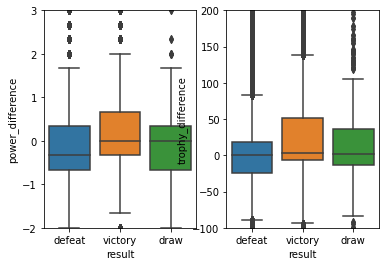

In [121]:
fig, ax = plt.subplots(1,2)
sns.boxplot(data = train, x = 'result', y = 'power_difference', ax = ax[0]).set(ylim=(-2,3))
sns.boxplot(data = train, x = 'result', y = 'trophy_difference', ax = ax[1]).set(ylim=(-100,200))

###Power

In this dataset, power is not very important. It has low feature importance score in DT and RF. Also, there is a minor improvement(< .2%) on model performance when we remove it. 

However, we should take into consideration that our data only include top players, who generally has high power brawlers. So lack of variance in power in our dataset could led to our result. 

Judeging from my gaming experience, in a more representative sample, power can be important.

In [ ]:
# dataset with power removed
#train_no_pow = train.drop('power', axis=1)
#test_no_pow = test.drop('power', axis=1)

## Brawler, map, mode
As mentioned earlier, these features are used to add general statistics to battle logs. As both teams plays the same mode on the same map in each battle, these should be independent of the game result.

In [124]:
indep = ['brawler', 'mode', 'map']

`catplot` allows comparison of distribution of a categorical feature `param: x` across a catagorical feature `param: col`.\
We can see that the distribution of these features are similar for win, lose, draw. 

One brawler(FANG) has higher victory counts than defeat count, because it was newly released. When player uses a new brawler, you get matched to lower trophy matches, which are easy for top players to win. Also Supercell made new brawlers "more powerful" to get people to buy them.

Having imbalance in games is unavoidable, so I will not exclude this bralwer's data(also we lose a large number of data removing it.)

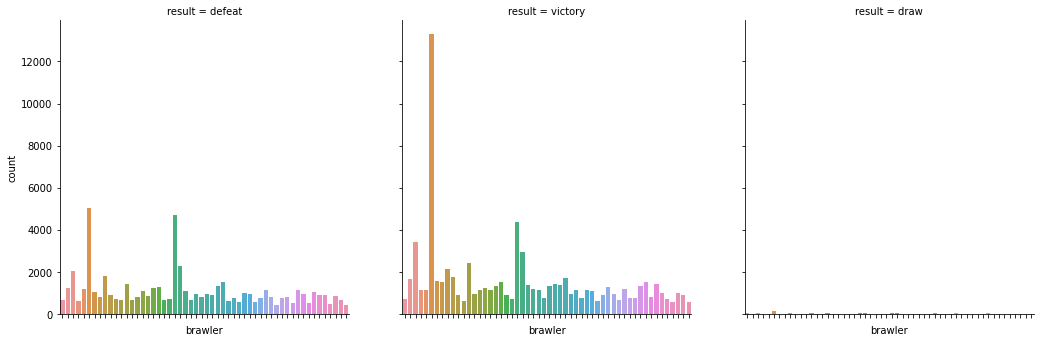

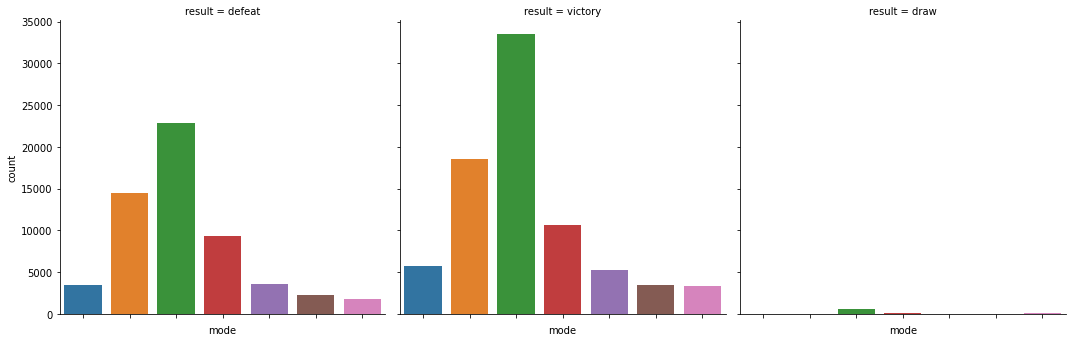

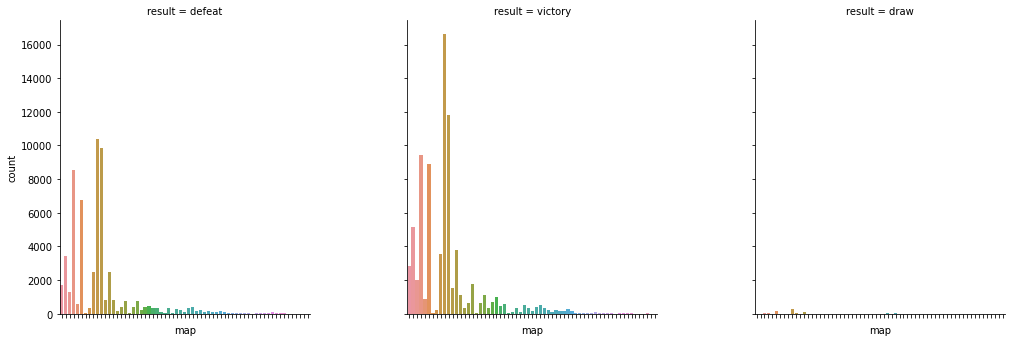

In [125]:
for i in range(0,3):
  sns.catplot(data = train, x = indep[i], col = 'result', 
              kind = 'count').set(xticklabels=[])

###Adding Features from General Statistics. 
Brawler, map and mode themselves does not contain valuable predicative information. However, certain brawlers perform better on particular modes and maps. So the combination of the two features can be a good predicative feature.\
We acquire the general stats of brawler's win rate sorted by maps from *Brawl Time Ninja*, and add this information to each battle (This data is updated regularly, visite the site to download the latest.)\
Then we will drop brawler and map columns.

In [140]:
from pandas.io.parsers import read_csv
path = '/content/drive/MyDrive/Colab Notebooks/brawler_map_winrate.csv'
b_map_win = pd.read_csv(path, index_col=False)
# match the col name to our battle_data to make merge easy
b_map_win.rename(columns={'Map':'map','Brawler':'brawler'}, inplace = True)

In [142]:
# merge with battle log data
train = pd.merge(train, b_map_win, on = ['brawler', 'map'])
train.rename(columns={'Adjusted Win Rate': 'win_rate'}, inplace=True)

test = pd.merge(test, b_map_win, on = ['brawler', 'map'])
test.rename(columns={'Adjusted Win Rate': 'win_rate'}, inplace=True)

In [143]:
# drop mode and map
train.drop(['mode', 'map', 'brawler'], inplace=True, axis = 1)
test.drop(['mode', 'map', 'brawler'], inplace=True, axis = 1)

Hypothesis to test: 
- teams with a positive trophy and power difference (having higher power/trophy than opponent) are more likely to win.
- Using brawler that has higher win rate on a chosen map is more likly to win.
- Player with higher team play to showdown ration(plays team battles more often) is more likly to win.
 

Split the data to prevent data leakage. You don't want information of your testing set to influence your analysis.\
Join them later when engineering features.

In [66]:
train, test = train_test_split(battle_data, test_size = 0.3)

In [76]:
train.info()
# map, result, brawler, mode are categorical vairables 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135599 entries, 63715 to 99906
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   result             135599 non-null  object 
 1   power              135599 non-null  float64
 2   b_trophies         135599 non-null  float64
 3   p_trophies         135599 non-null  float64
 4   3v3_win            135599 non-null  float64
 5   solo_win           135599 non-null  float64
 6   duo_win            135599 non-null  float64
 7   exp_level          135599 non-null  float64
 8   trophy_difference  135599 non-null  float64
 9   power_difference   135599 non-null  float64
 10  win_rate           135599 non-null  float64
dtypes: float64(10), object(1)
memory usage: 16.4+ MB


Our data contains more wins than loses. This can be a potential issue for some models. Our final models are Tree Models, so imbalanced class is not an issue. 

*I also ran a test using a balanced testing set and verified that my model was not gussing 60% true.*

In [68]:
train.groupby('result').count() 

,power,b_trophies,p_trophies,3v3_win,solo_win,duo_win,exp_level,trophy_difference,power_difference,win_rate
result,,,,,,,,,,
defeat,56630,56630,56630,56630,56630,56630,56630,56630,56630,56630
draw,724,724,724,724,724,724,724,724,724,724
victory,78245,78245,78245,78245,78245,78245,78245,78245,78245,78245


## Solo/duo Wins v.s. 3v3 Wins
Solo and duo showdowns are game modes where players seek to survive either for themselves among 9 other players or in a team of 2 among 4 other teams. The gaming machanism is very different from 3v3 team battles, so players are likely to develop different gaming strategy for these modes.\
Therefore, we assume that **player who have a higher proportion of 3v3 wins performs better on 3v3 battles.**

`Facetgrid` explores conditional relationships.\
We can use it to examine the distribution of numerical variable across different results.


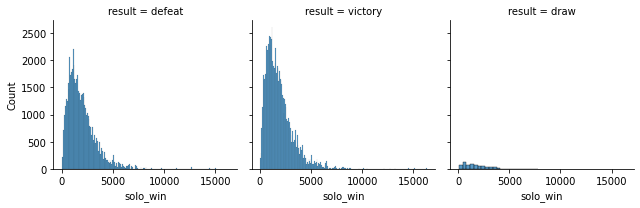

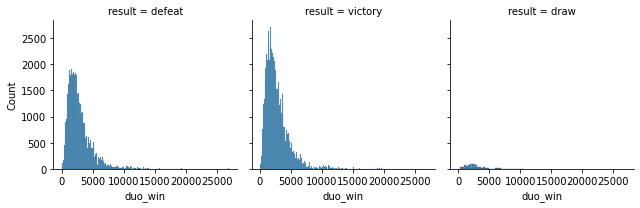

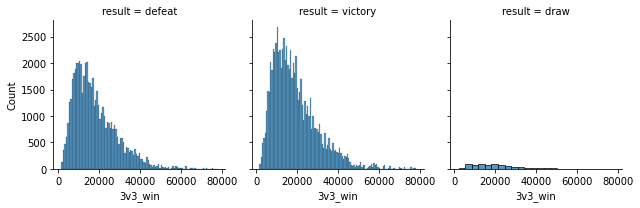

In [145]:
wins = ['solo_win', 'duo_win', '3v3_win']
for i in range(0,3):
  g = sns.FacetGrid(col = 'result', data = train)
  g.map(sns.histplot, wins[i])

There is little we can say about the relationship between the numbers wins and game result. This makes sense since two players can have different total number of game played, so maginitude of the count should give us little information. 

We will transform the data into a 3v3_win/ (solo_win + duo_win) ratio instead. \

Update: Because there are player with 0 record of showdown win, to avoid 0 in the denominator, we compute 3v3 wins over total wins.\
Update: Because there are 4 modes that are teams plays versus 2 showdowns, we adjusted the ratio with coefficients.


In [172]:
train['team_win_ratio'] = round(
    (train['3v3_win']/4) / ((train['duo_win'] + train['solo_win'])/2 + (train['3v3_win']/4)), 3)

In [175]:
test['team_win_ratio'] = round(
    (test['3v3_win']/4) / ((test['duo_win'] + test['solo_win'])/2 + (test['3v3_win']/4)), 3)

In [173]:
train['team_win_ratio'].describe()

count    135584.000000
mean          0.637815
std           0.173703
min           0.100000
25%           0.516000
50%           0.652000
75%           0.772000
max           1.000000
Name: team_win_ratio, dtype: float64

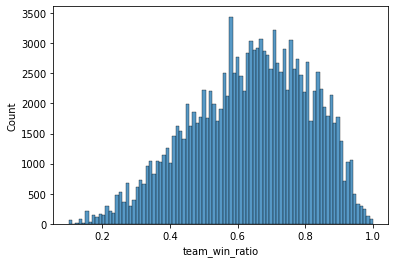

In [174]:
sns.histplot(data=train, x = 'team_win_ratio')

[(0.2, 1.0)]

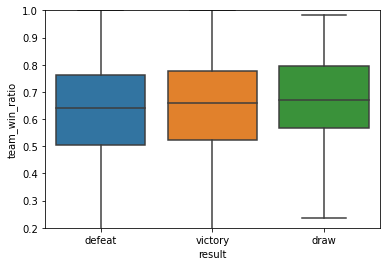

In [176]:
sns.boxplot(x='result', y='team_win_ratio',
            data=train).set(ylim=(0.2,1.0))

The graph does not show an obvious correlation, but some of our model suggested that the feature provides some information. We keep the team win_ratio and drop the 3 win counts.

In [177]:
test.drop(['solo_win', 'duo_win', '3v3_win'], inplace=True, axis = 1)
train.drop(['solo_win', 'duo_win', '3v3_win'], inplace=True, axis = 1)

##Player Information
In this section, we examine the relationship between a player's brawler trophy, total trophy, and exp level.

(120.0, 440.0)

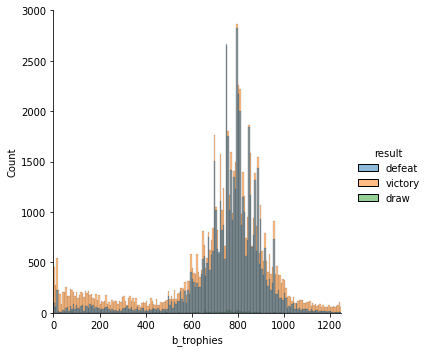

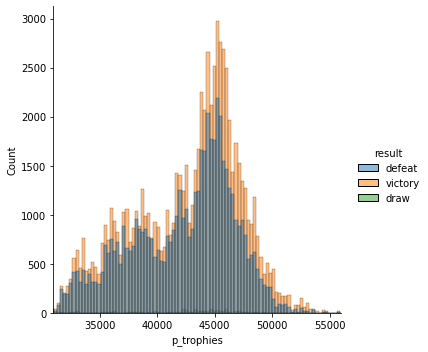

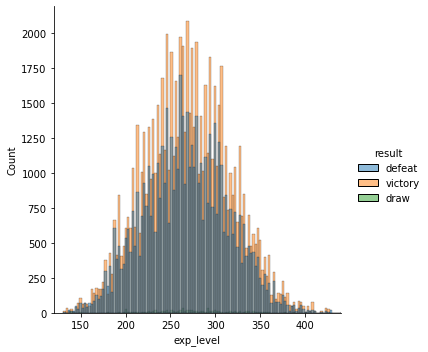

In [178]:
sns.displot(train, x='b_trophies', hue='result')
plt.xlim(0,1250)
sns.displot(train, x='p_trophies', hue='result')
plt.xlim(31000,56000)
sns.displot(train, x='exp_level', hue='result')
plt.xlim(120,440)

The graph shows that the win/lose count difference seem to be greater around certain values. We will keep these features.

#Feature Engineering 


In [179]:
train.groupby(by='result').count()

,power,b_trophies,p_trophies,exp_level,trophy_difference,power_difference,win_rate,team_win_ratio
result,,,,,,,,
defeat,56462,56462,56462,56462,56462,56462,56462,56462
draw,719,719,719,719,719,719,719,719
victory,78403,78403,78403,78403,78403,78403,78403,78403


Because draws are very rare, 725/134874, we will just drop the entries with draw result.

In [180]:
train = train[train.result != 'draw']
test = test[test.result != 'draw']

Convert categorical values to numbers.

In [ ]:
train['result'] = train['result'].map({'victory': 1, 'defeat': 0 }).astype(int)
test['result'] = test['result'].map({'victory': 1, 'defeat': 0 }).astype(int)

#Modelling
Our goal is to predict, given a player's pregame information, whether the player can win or not, requiring a **binary classification** model. Therefore, we consider the following ML models:


*   SGD
*   LinearRegression
*   Decision Tree
*   RandomForest
*   KNN 
*   XGBClassifier
* Naive Bayes
* Perceptron


Import modules.

In [186]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [187]:
X, x_test = train.drop('result', axis = 1), test.drop('result', axis = 1)
y, y_test = train['result'], test['result']

Dataset for testing power feature:

In [ ]:
#X_1, x_test_1 = train_no_pow.drop('result', axis = 1), test_no_pow.drop('result', axis = 1)
#y_1, y_test_1 = train_no_pow['result'], test_no_pow['result']

##Decision Tree 
Best hyper parameters: 

max depth| min_samples_split
--------|---------------- 
34 | 2

Accuracy improved from
69.981 to 84% when more training data is added.
Best hyperparameters did not change.
                      

In [188]:
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=34, 
                                       min_samples_split=2)
decision_tree.fit(X, y)

DecisionTreeClassifier(max_depth=34, random_state=0)

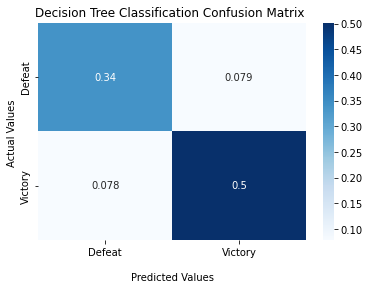

In [191]:
preds = decision_tree.predict(x_test)
cf_matrix = confusion_matrix(y_test, preds)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap='Blues')

ax.set_title('Decision Tree Classification Confusion Matrix ');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Defeat','Victory'])
ax.yaxis.set_ticklabels(['Defeat','Victory'])

## Display the visualization of the Confusion Matrix.
plt.show()

###Feature Importance

In [192]:
importance = decision_tree.feature_importances_
for i,v in enumerate(importance):
	print('Feature: {}, Score: {}'.format(X.columns[i],v))

Feature: power, Score: 0.024518291401161907
Feature: b_trophies, Score: 0.18051067664020196
Feature: p_trophies, Score: 0.1267033359472476
Feature: exp_level, Score: 0.1128427689947055
Feature: trophy_difference, Score: 0.2245943317050426
Feature: power_difference, Score: 0.06933529297673759
Feature: win_rate, Score: 0.1295834160223615
Feature: team_win_ratio, Score: 0.13191188631254128


###Tuning

In [ ]:
X.columns

Index(['b_trophies', 'p_trophies', 'exp_level', 'trophy_difference',
       'power_difference', 'win_rate', 'team_win_ratio'],
      dtype='object')

In [ ]:
from pandas.core.common import random_state
dt_hyper_param = {
    'max_depth' : [24,26,28,30,32,34],
    'min_samples_split':[2,3,4,5,6],
    'random_state' : [1]
}
def tuneDT(params):
  grid = GridSearchCV(decision_tree, params)
  grid.fit(X,y)
  preds = grid.predict(x_test)
  acc_dt_grid = round(accuracy_score(y_test,preds) * 100, 3)
  print(acc_dt_grid)
  print(grid.best_params_)
  return grid.best_params_


In [ ]:
# tune decision tree
best_dt_param = tuneDT(dt_hyper_param)

84.063
{'max_depth': 34, 'min_samples_split': 2, 'random_state': 1}


##RandomForest 
Best hyper parameters: 

 Data Size|max depth| min_samples_split
--------|---------|------- 
small |20 | 6
large | 3| 200


Accuracy score improved from 73.454 to 86.343 when more training data is added.


In [193]:
# takes ~ 1 min to run 
randforst = RandomForestClassifier(n_estimators= 200, random_state = 1,
                                   max_depth = 48, min_samples_split=3)
randforst.fit(X, y)

RandomForestClassifier(max_depth=48, min_samples_split=3, n_estimators=200,
                       random_state=1)

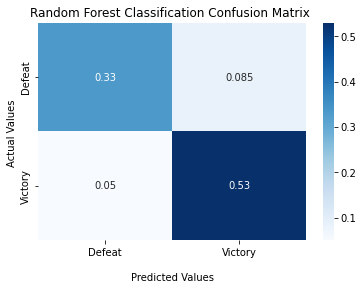

In [194]:
preds = randforst.predict(x_test)
cf_matrix = confusion_matrix(y_test, preds)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap='Blues')

ax.set_title('Random Forest Classification Confusion Matrix ');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Defeat','Victory'])
ax.yaxis.set_ticklabels(['Defeat','Victory'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [195]:
importance = randforst.feature_importances_
for i,v in enumerate(importance):
	print('Feature: {}, Score: {}'.format(X.columns[i],v))

Feature: power, Score: 0.03523644771405805
Feature: b_trophies, Score: 0.16972760657284042
Feature: p_trophies, Score: 0.13187181453455069
Feature: exp_level, Score: 0.11959208473310123
Feature: trophy_difference, Score: 0.20813007510817555
Feature: power_difference, Score: 0.07752343528567647
Feature: win_rate, Score: 0.12931488897618976
Feature: team_win_ratio, Score: 0.12860364707540786


Tuning 

In [ ]:
rf_hyper_param = {
    'max_depth' : [48, 50, 52],
    'min_samples_split':[3],
    'random_state' : [1],
}
def tuneRF(params):
  grid = GridSearchCV(randforst, params)
  grid.fit(X,y)
  preds = grid.predict(x_test)
  acc_dt_grid = round(accuracy_score(y_test,preds) * 100, 3)
  print(acc_dt_grid)
  print(grid.best_params_)
  return grid.best_params_

In [ ]:
rf_best_param = tuneRF(rf_hyper_param)

86.155
{'max_depth': 48, 'min_samples_split': 3, 'random_state': 1}


#XGBClassifier 

  score   |    eta    |early stop|n_estimator | gamma| max_depth| min_cw|colsample|subsample
--------- | --------- | ------ | ------------ |------|-----|-----|-----|----
63.81     |   0.1     |   20   |     1000     | 0.1  |  3  |  5  | 0.6 | 0.9
68.673    |   0.01    |   20   |     1000     | 0.0  |  9  |  1  | 0.9 | 0.8
72.711    |   0.05    |   30   |     1000     | 0.0  |  9  |  1  | 0.9 | 0.8
73.185    |   0.02    |   100  |     1000     | 0.0  |  9  |  1  | 0.9 | 0.8

Same hypreparameters with new dataset:77%

In [196]:
from xgboost import XGBRegressor
from scipy import rand

from sklearn.metrics import accuracy_score, mean_absolute_error

In [197]:
# Validation set
X_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2) 
# 0.7 * 0.2 = 0.14 validation
X_train.columns

Index(['power', 'b_trophies', 'p_trophies', 'exp_level', 'trophy_difference',
       'power_difference', 'win_rate', 'team_win_ratio'],
      dtype='object')

In [ ]:
# running takes 3 mins on 200k data 
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(n_estimators = 1000, 
                    learning_rate = 0.02,
                    max_depth=9,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.9,
                    objective= 'binary:logistic',
                    verbosity = 0,
                    random_state=1)
xgb.fit(X_train, y_train, eval_set=[(X_train, y_train),(x_val,y_val)],
        early_stopping_rounds=100)


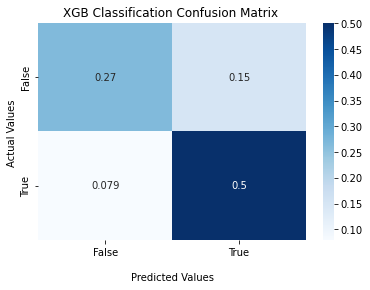

In [199]:
preds = xgb.predict(x_test)
acc_xgb = accuracy_score(y_test, preds)
#acc_xgb 
cf_matrix = confusion_matrix(y_test, preds)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap='Blues')

ax.set_title('XGB Classification Confusion Matrix ');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

###Feature Importance

In [200]:
importance = xgb.feature_importances_
for i,v in enumerate(importance):
	print('Feature: {}, Score: {}'.format(X.columns[i],v))

Feature: power, Score: 0.11738042533397675
Feature: b_trophies, Score: 0.13722120225429535
Feature: p_trophies, Score: 0.12576620280742645
Feature: exp_level, Score: 0.11527597904205322
Feature: trophy_difference, Score: 0.13981512188911438
Feature: power_difference, Score: 0.11810553818941116
Feature: win_rate, Score: 0.12368840724229813
Feature: team_win_ratio, Score: 0.12274710834026337


###Tuning 
Tune Tree related parameters : `max_depth`[3,10], `min_child_weight`[1,6], `gamma`[0-1], `subsample`(0,1], `colsample_bytree` 

In [ ]:
param_1 = { # 9 ,1
    'max_depth' : range(3, 10, 1),
    'min_child_weight' : range(1, 6, 2)
}
grids1 = GridSearchCV(estimator = XGBClassifier(n_estimators = 100, 
                    learning_rate =0.1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    random_state=1), 
                    param_grid = param_1, scoring='roc_auc')
grids1.fit(X_train,y_train)
grids1.best_params_, grids1.best_score_

({'max_depth': 9, 'min_child_weight': 1}, 0.7809424268214442)

In [ ]:
param_2 = {
    'gamma' : [i/10.0 for i in range(0,6)]
}
grids2 = GridSearchCV(estimator = XGBClassifier(n_estimators = 100, 
                    learning_rate =0.1,
                    max_depth=9,
                    min_child_weight=1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    random_state=1), 
                    param_grid = param_2, scoring='roc_auc')
grids2.fit(X_train,y_train)
grids2.best_params_, grids2.best_score_

({'gamma': 0.0}, 0.7809424268214442)

In [ ]:
param_3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
grids3 = GridSearchCV(estimator = XGBClassifier(n_estimators = 100, 
                    learning_rate =0.1,
                    max_depth=9,
                    min_child_weight=1,
                    gamma=0,
                    objective= 'binary:logistic',
                    random_state=1), 
                    param_grid = param_3, scoring='roc_auc')
grids3.fit(X_train,y_train)
grids3.best_params_, grids3.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.8}, 0.7812489001101606)

##Some less ideal models 

In [ ]:
nb = GaussianNB()
nb.fit(X_norm, y)
preds = nb.predict(test_norm)
acc = round(accuracy_score(y_test, preds) * 100, 3)
acc

55.985

In [ ]:
pct = Perceptron()
pct.fit(X, y)
preds = pct.predict(x_test)
acc = round(accuracy_score(y_test, preds) * 100, 3)
acc

58.392

In [ ]:
sgd = SGDClassifier()
sgd.fit(X, y)
preds = sgd.predict(x_test)
acc = round(accuracy_score(y_test, preds) * 100, 3)
acc

60.359

In [ ]:
logr = LogisticRegression()
logr.fit(X,y)
preds = logr.predict(x_test)
acc_logr = round(accuracy_score(y_test,preds) * 100, 3)
acc_logr

60.971

##Saving Model with pickle.##

Random Forest and Decision Tree has shown to have significant improvement when size of training set is larger. We might consider saving the model and improving it with new training data.
 

In [ ]:
# save the model to disk
import pickle 
model_name = ""
path = '/content/drive/MyDrive/Colab Notebooks/{}model_{}.sav'.format(model_name,'0212')

pickle.dump(model_name, open(path, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(path, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

#Conclusion
We found that Tree models(Decision Tree, Random Forest, and XGBoost) are the best at predicting the outcome of a match given pre-game information only.

At the same time, there is no sign of a strong pridicative feature, which suggested further feature selection. My personal take on this is to combine domain knowledge and design models that targets specific game modes/types of players. This will allow us to get a more straight forward sense of how each feature affect the match result. Generalizing all matches is possibly why we got no feature with high feature importance.

Also, another improvement is to include lower ranking players (which cannot be done efficiently with Supercell API). Having top ranking players result in many features having low variance, which is not the general case. 